In [368]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

In [3]:
# load bochum data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

In [11]:
# load the RPN-signature (trained on sample 1):
# load trained finalized models
model_bochum = joblib.load('model_trained_on_bochum.joblib') #RPN-signature
model_essen = joblib.load('model_trained_on_essen.joblib')
model_szeged = joblib.load('model_trained_on_szeged.joblib') 

model_bochum_essen = joblib.load('model_trained_on_bochum+essen.joblib')
model_bochum_szeged = joblib.load('model_trained_on_bochum+szeged.joblib')
model_essen_szeged = joblib.load('model_trained_on_essen+szeged.joblib') 

model_bochum_essen_szeged = joblib.load('model_trained_on_all.joblib') 

models = {
    'study1': model_bochum,
    'study2': model_essen,
    'study3': model_szeged,
    'study1+2': model_bochum_essen,
    'study1+3': model_bochum_szeged,
    'study2+3': model_essen_szeged,
    'study1+2+3': model_bochum_essen_szeged
}


In [142]:
#get region names from an arbitrary timeseries file
ts = pd.read_csv('../data/bochum-sample/regional_timeseries/bochum-023_pumi-17-scrubbed.tsv').iloc[:,1:] 
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

# function to extract predictive weights:
def get_weights(model, labels=labels, modules=modules):
    RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

    featuremask = model.named_steps['fsel'].get_support()
    RES[featuremask] = model.named_steps['model'].coef_
    
    RES_MAT = vec_to_sym_matrix(RES, diagonal=np.repeat(0, len(labels)))
    return RES_MAT
    

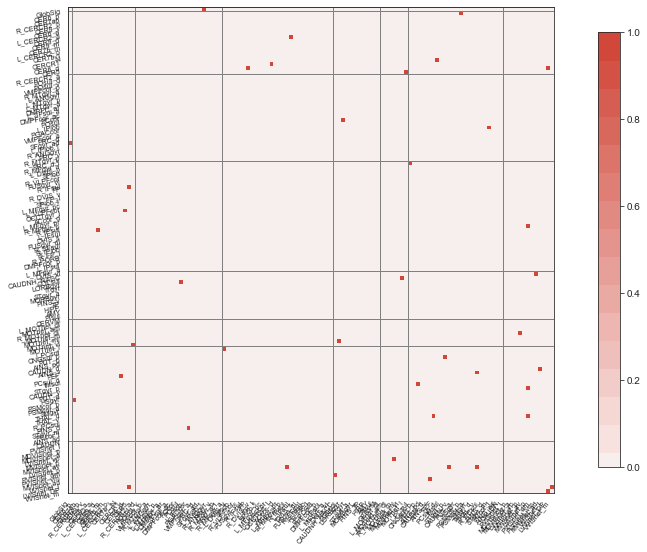

In [13]:
plot.plot_matrix(get_weights(models['study1'])!=0, labels, modules)

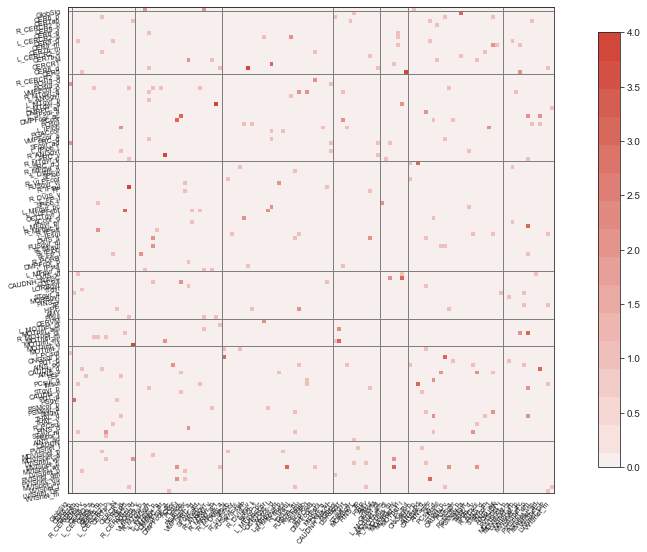

In [17]:
res = np.zeros_like(get_weights(models['study1']))

for m in models:
    binarized = np.array(get_weights(models[m])!=0, dtype=int)
    res += binarized

plot.plot_matrix(res, labels, modules)

In [40]:
for idx in np.argwhere(np.triu(res)==4):
        print(labels[idx])
        for m in models:
            print(m, get_weights(models[m])[idx[0], idx[1]])
    

['CER5' 'FP']
study1 0.24527388960654029
study2 0.0
study3 0.0
study1+2 0.28057141113023004
study1+3 0.05183274022229465
study2+3 0.0
study1+2+3 0.02617332048484226
['R_CERCR2_a' 'MOTnet_l']
study1 0.14963364866374754
study2 0.0
study3 0.0
study1+2 0.1030750942787392
study1+3 0.023218666449453425
study2+3 0.0
study1+2+3 0.11715966194422313
['DMPFC_ar' 'R_MTgyr_p']
study1 0.0
study2 -0.19122715036491925
study3 0.0
study1+2 -0.1790067840078974
study1+3 0.0
study2+3 -0.10499578320898825
study1+2+3 -0.1124892714374555


In [42]:
for idx in np.argwhere(np.triu(res)==3):
        print(labels[idx])
        for m in models:
            print(m, get_weights(models[m])[idx[0], idx[1]])

['CER6_p' 'PSMcor_p']
study1 -0.20061663073450295
study2 0.0
study3 0.0
study1+2 -0.1371052686019329
study1+3 0.0
study2+3 0.0
study1+2+3 -0.0855765613456176
['CER6_d' 'OCCTgyr_l']
study1 -0.056635124908851836
study2 0.0
study3 0.0
study1+2 0.0
study1+3 -0.059144920134329884
study2+3 0.0
study1+2+3 -0.03407297445036419
['PCcor' 'POsul']
study1 0.0
study2 0.10747661931402354
study3 0.0
study1+2 0.021336529478510145
study1+3 0.0
study2+3 0.11970747476993412
study1+2+3 0.0
['R_MFgyr_a' 'PUT_p']
study1 0.0
study2 -0.0
study3 0.0
study1+2 -0.05615883773134488
study1+3 0.0
study2+3 -0.15112140435134475
study1+2+3 -0.09366437841742539
['R_IPsul' 'LVISnet_p']
study1 -0.05391336300274952
study2 0.0
study3 0.0
study1+2 0.0
study1+3 -0.04379976153654378
study2+3 0.0
study1+2+3 -0.013676886880987317
['COLsul' 'MOTnet_vl']
study1 -0.06249051984068541
study2 0.0
study3 0.0
study1+2 0.0
study1+3 -0.0772250989182935
study2+3 0.0
study1+2+3 -0.032812851076074914
['MOTnet_m' 'LVISnet_p']
study1 0.0
stud

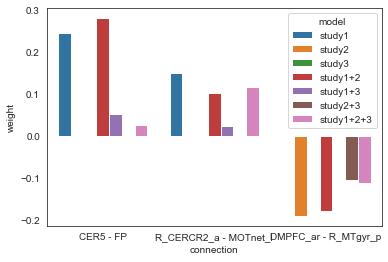

In [70]:
x = []
weights = []
model = []

for idx in np.argwhere(np.triu(res)>=4): 
    for m in models:
        x.append(labels[idx][0] + ' - ' + labels[idx][1])
        model.append(m)
        weights.append(get_weights(models[m])[idx[0], idx[1]])

df_weights = pd.DataFrame({
    "connection": x,
    "weight" : weights,
    "model" : model
})
sns.barplot(data=df_weights, x='connection', y='weight', hue='model')

# polar plots

78

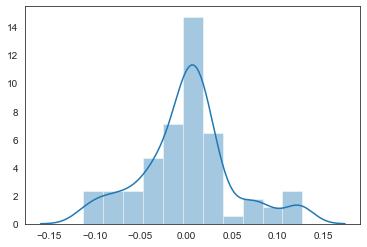

In [176]:
ref = get_weights(models['study1+2+3'])[np.triu_indices(len(labels))]
                  
sns.distplot(ref[ref!=0].flatten())
len(ref[ref!=0])

In [212]:
def polar_plot(model, weight, actual):
    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(2, 2))
    plt.subplot(polar=True)

    weight.append(weight[0])
    theta = np.linspace(0, 2 * np.pi, len(weight))

    # Arrange the grid into number of sales equal parts in degrees
    lines, lab = plt.thetagrids(range(0, 360, int(360/len(model))), (model))
    # Plot actual sales graph
    #plt.plot(theta, weight)
    plt.fill_between(theta, np.repeat(0, len(weight)), weight, color='b', alpha=0.6)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    #plt.ylim((min(np.min(weight), -0.1),np.max(weight)))
    plt.ylim((-0.2,0.3))
    plt.plot(theta, np.repeat(0, len(weight)), color='gray', linestyle=':')
    plt.plot(theta, np.repeat(actual, len(weight)), color='red', linestyle=':')
    
 

0.1269778407219833
[0.0, 0.08085144515561188, 0.0, 0.0, 0.0, 0.0, 0.0]


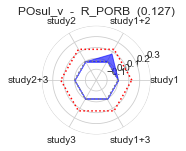

0.1234682714370146
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


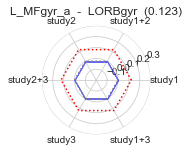

0.12310536982842522
[0.0, 0.17754612838092207, 0.0, 0.0, 0.0, 0.0, 0.0]


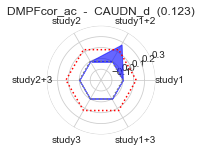

0.11715966194422313
[0.14963364866374754, 0.1030750942787392, 0.0, 0.0, 0.0, 0.023218666449453425, 0.14963364866374754]


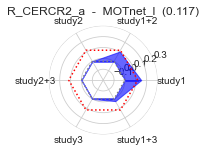

0.1124892714374555
[0.0, -0.1790067840078974, -0.19122715036491925, -0.10499578320898825, 0.0, 0.0, 0.0]


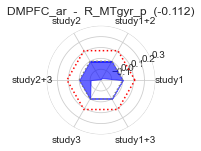

0.10850177426946678
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


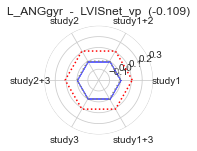

0.09875549878721727
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


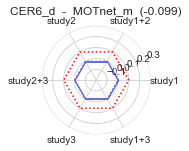

0.09366437841742539
[0.0, -0.05615883773134488, -0.0, -0.15112140435134475, 0.0, 0.0, 0.0]


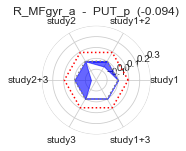

0.08778235681367658
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


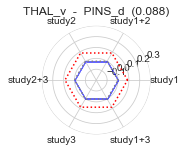

0.0855765613456176
[-0.20061663073450295, -0.1371052686019329, 0.0, 0.0, 0.0, 0.0, -0.20061663073450295]


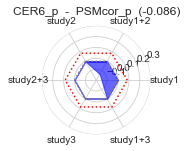

0.08438172603731801
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0138503842129624, 0.0]


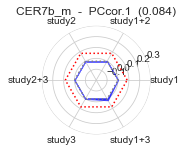

0.08331076732212897
[0.0, 0.0, 0.0, -0.10855814515001266, 0.0, 0.0, 0.0]


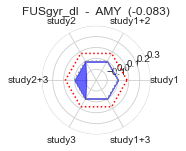

0.07698243047949312
[0.0, 0.11279667834318395, 0.0, 0.10983111519829082, 0.0, 0.0, 0.0]


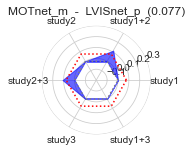

0.07366059984874464
[0.0, 0.0, 0.0, 0.0, -0.033204477984381225, 0.0, 0.0]


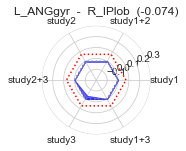

0.0724956057971822
[-0.04423685507382765, 0.0, 0.0, 0.0, 0.0, -0.04244416726454939, -0.04423685507382765]


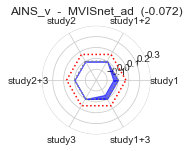

0.0698034560459715
[0.0, 0.0, 0.0, 0.05709750051081565, 0.0, 0.0, 0.0]


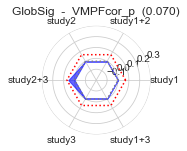

0.06215743075757072
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


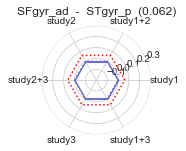

0.05954240203128288
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


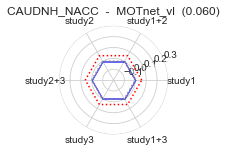

0.059270135305668235
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


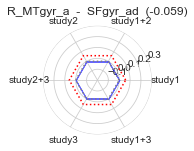

0.05911984091544371
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


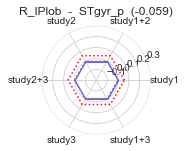

0.057494485203595715
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


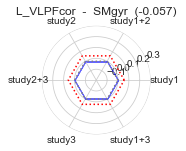

0.04928444952474809
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


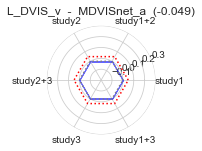

0.042244630108449865
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


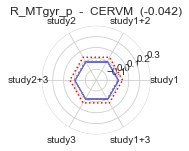

0.040547541944836216
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


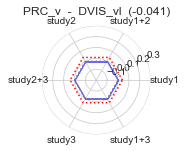

0.03593244004093791
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


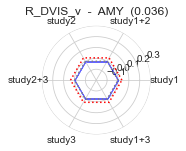

0.03501106516445056
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


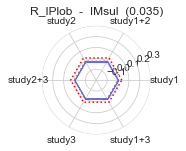

0.03436201291367594
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


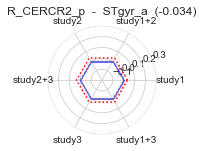

0.03407297445036419
[-0.056635124908851836, 0.0, 0.0, 0.0, 0.0, -0.059144920134329884, -0.056635124908851836]


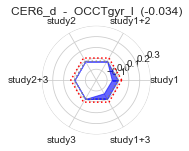

0.03287766961697691
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


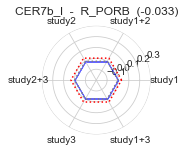

0.032812851076074914
[-0.06249051984068541, 0.0, 0.0, 0.0, 0.0, -0.0772250989182935, -0.06249051984068541]


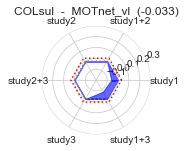

0.03142691659328145
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


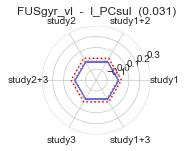

0.02994077538489299
[0.0, 0.0, 0.0, -0.08842659196365292, 0.0, 0.0, 0.0]


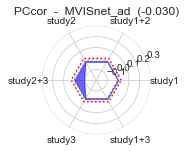

0.029721462917484887
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


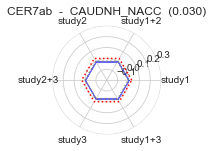

0.02920363001032178
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


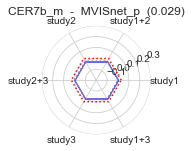

0.027806678408399222
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


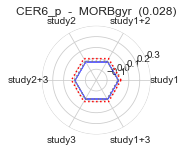

0.026639657077632422
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


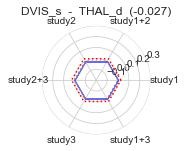

0.02617332048484226
[0.24527388960654029, 0.28057141113023004, 0.0, 0.0, 0.0, 0.05183274022229465, 0.24527388960654029]


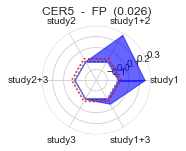

0.024331715327701845
[0.0, 0.05154186486013198, 0.0, 0.0, 0.0, 0.0, 0.0]


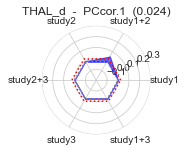

0.02402555185788283
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


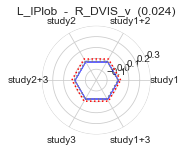

0.023375339712012465
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


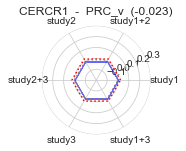

In [213]:
ref = np.triu(get_weights(models['study1+2+3']))
abs_ref = np.abs(ref)
model_names = ['study1', 'study1+2', 'study2', 'study2+3', 'study3', 'study1+3']

#num = np.sum(ref!=0)
num = 40

for i in range(num):
    print(np.max(abs_ref))
    nextmax_idx = np.argwhere(abs_ref==np.max(abs_ref))
    if nextmax_idx.shape[0] != 1:
          raise RuntimeError('tie:', nextmax_idx)
    else:
        nextmax_idx = nextmax_idx[0]
        labs = labels[nextmax_idx]
        weights = []
        for m in model_names:
            weights.append(get_weights(models[m])[nextmax_idx[0], nextmax_idx[1]])
        polar_plot(model_names, weights, abs_ref[nextmax_idx[0], nextmax_idx[1]])
        plt.title(labs[0] + "  -  " + labs[1] + "  ({:.3f})".format(ref[nextmax_idx[0], nextmax_idx[1]]))
        print(weights)
        plt.show()
                 
    abs_ref[nextmax_idx[0], nextmax_idx[1]] = -np.inf


### same for "nodal predictive strength"

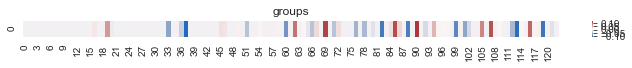

0.1313625143532103
[0.0, 0.17754612838092207, 0.05863196350794197, 0.0, 0.056157134888780116, 0.0]


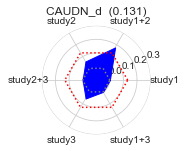

0.1234682714370146
[0.0030063192931109417, 0.0, 0.08777946202761383, 0.0, 0.0, 0.04914392718665325]


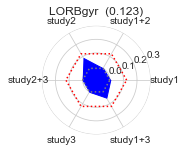

0.11715966194422313
[0.14963364866374754, 0.1030750942787392, 0.0, 0.0, 0.0, 0.023218666449453425]


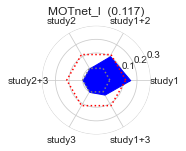

0.11348933107279426
[0.0, 0.05154186486013198, 0.0, 0.05363267350121968, 0.03187509624843781, 0.0138503842129624]


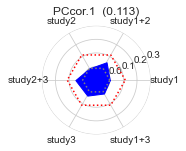

0.1124892714374555
[0.0, 0.1790067840078974, 0.19122715036491925, 0.10499578320898825, 0.0, 0.0]


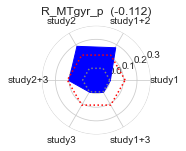

0.10850177426946678
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


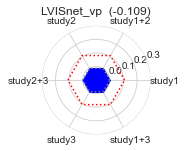

0.10243638118207518
[0.04423685507382765, 0.006567080094998659, 0.0, 0.08842659196365292, 0.0, 0.04244416726454939]


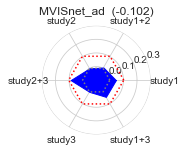

0.10167210716022489
[0.19668462014554272, 0.11279667834318395, 0.0, 0.10983111519829082, 0.0, 0.10945887289343678]


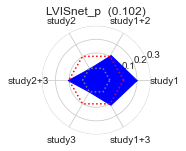

0.09875549878721727
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


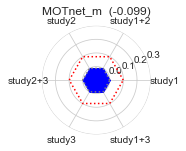

0.09410017110500637
[0.0, 0.08085144515561188, 0.0, 0.0, 0.0, 0.0]


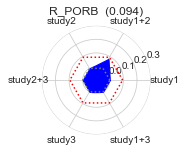

0.09366437841742539
[0.0, 0.05615883773134488, 0.0, 0.15112140435134475, 0.0, 0.0]


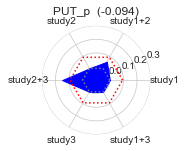

0.0855765613456176
[0.20061663073450295, 0.1371052686019329, 0.13560138663812374, 0.0, 0.0, 0.0]


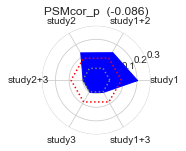

0.08137732579970644
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


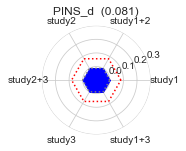

0.07366059984874464
[0.0, 0.0, 0.0, 0.0, 0.033204477984381225, 0.0]


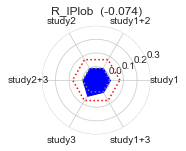

0.0698034560459715
[0.0, 0.0, 0.0, 0.05709750051081565, 0.0, 0.0]


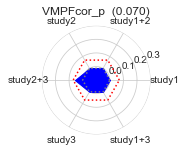

0.059270135305668235
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


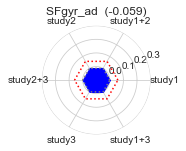

0.057494485203595715
[0.0, 0.0, 0.0, 0.0, 0.02912792141339461, 0.0]


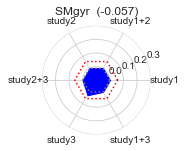

0.05148273356051533
[0.0, 0.1370682122879976, 0.0, 0.0, 0.0, 0.0]


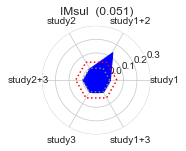

0.04737832728119106
[0.0, 0.0, 0.020945811752988458, 0.10855814515001266, 0.0, 0.0]


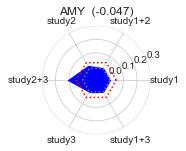

0.042244630108449865
[0.0, 0.0, 0.048006372400379985, 0.03442504627881182, 0.0, 0.0]


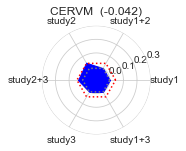

0.04151249118434429
[0.0, 0.0, 0.0, 0.0, 0.02973997543938874, 0.0]


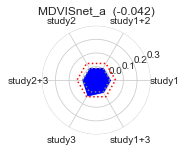

0.03436201291367594
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


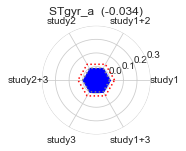

0.034298249923158525
[0.0, 0.04931977182872833, 0.0, 0.0, 0.0, 0.0]


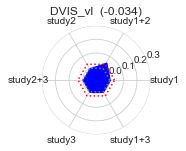

0.03407297445036419
[0.056635124908851836, 0.03548358816759416, 0.31919508850274025, 0.03084616692340368, 0.0, 0.059144920134329884]


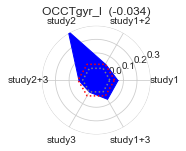

0.03142691659328145
[0.0427850094210493, 0.0, 0.0, 0.0, 0.0, 0.0]


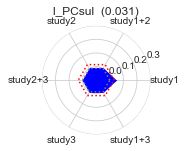

0.029721462917484887
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


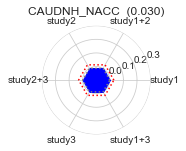

0.027806678408399222
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


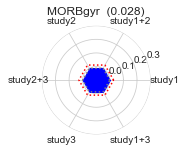

0.026729550955207966
[0.06249051984068541, 0.0, 0.2197332931675818, 0.006030191729028742, 0.0, 0.0772250989182935]


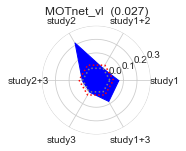

0.02617332048484226
[0.24527388960654029, 0.28057141113023004, 0.0, 0.0, 0.0, 0.05183274022229465]


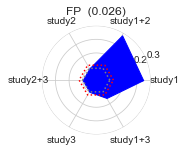

0.02402555185788283
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


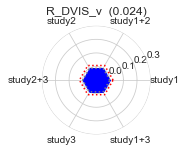

0.023375339712012465
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


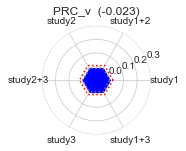

0.02259885090545514
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


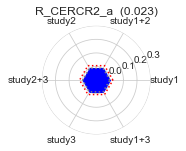

0.016923970329904732
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


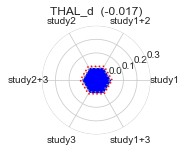

0.01625612970147971
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


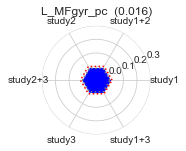

0.016107740255113738
[0.0, 0.0, 0.0, 0.0, 0.22931652741353598, 0.0]


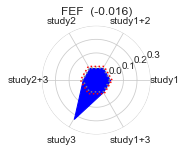

0.016017703030024137
[0.0, 0.0, 0.04686435232588488, 0.0, 0.0, 0.0]


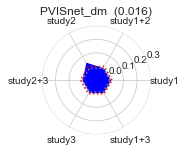

0.01329345156233235
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


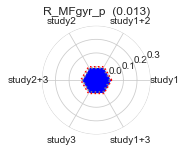

0.013179377732742739
[0.27023180074984365, 0.128107653414092, 0.12354345762700379, 0.0, 0.0, 0.0]


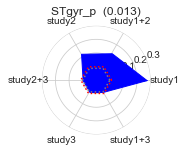

0.01278792733766481
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


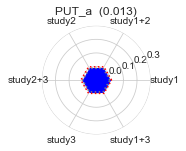

0.011224056769446149
[0.10246776200510883, 0.20996095577014603, 0.0, 0.0, 0.0, 0.0]


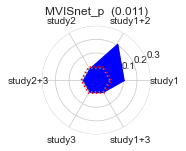

In [220]:
def polar_plot(model, weight, actual):
    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(2, 2))
    plt.subplot(polar=True)

    weight.append(weight[0])
    theta = np.linspace(0, 2 * np.pi, len(weight))

    # Arrange the grid into number of sales equal parts in degrees
    lines, lab = plt.thetagrids(range(0, 360, int(360/len(model))), (model))
    # Plot actual sales graph
    #plt.plot(theta, weight)
    plt.fill_between(theta, np.repeat(-0.1, len(weight)), weight, color='b', alpha=1)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    #plt.ylim((min(np.min(weight), -0.1),np.max(weight)))
    plt.ylim((-0.1,0.3))
    plt.plot(theta, np.repeat(0, len(weight)), color='gray', linestyle=':')
    plt.plot(theta, np.repeat(actual, len(weight)), color='red', linestyle=':')
    
 

ref = np.sum(np.triu(get_weights(models['study1+2+3'])), 0) # row sums as "nodal strength"
plt.figure(figsize=(12, 0.3))
sns.heatmap([ref], cmap="vlag").set_title('groups')
plt.show()

abs_ref = np.abs(ref)
model_names = ['study1', 'study1+2', 'study2', 'study2+3', 'study3', 'study1+3']

#num = np.sum(ref!=0)
num = 40

for i in range(num):
    print(np.max(abs_ref))
    nextmax_idx = np.argwhere(abs_ref==np.max(abs_ref))
    if nextmax_idx.shape[0] != 1:
          raise RuntimeError('tie:', nextmax_idx)
    else:
        nextmax_idx = nextmax_idx.flatten()[0]
        labs = labels[nextmax_idx]
        weights = []
        for m in model_names:
            weights.append(np.sum(np.abs(np.triu(get_weights(models[m]))), 0)[nextmax_idx])
        print(weights)
        polar_plot(model_names, weights, abs_ref[nextmax_idx])
        plt.title(labs + "  ({:.3f})".format(ref[nextmax_idx]))
        plt.show()
                 
    abs_ref[nextmax_idx] = -np.inf


# RPN-features

In [346]:
rpn_conns = pd.read_csv("../res/predictive_connections.csv")
rpn_conns['abs_weight'] = rpn_conns['weight'].abs()
rpn_conns = rpn_conns.sort_values('abs_weight', ascending=False)
rpn_conns = rpn_conns.reset_index()
rpn_conns

,index,Unnamed: 0,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight
0,15,15,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232
1,5,5,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274
2,1,1,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617
3,7,7,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634
4,14,14,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468
5,20,20,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911
6,0,0,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423
7,18,18,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078
8,12,12,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571
9,13,13,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491


In [347]:
#create a similar table from the multi-center signsature
RES_MAT = get_weights(models['study1+2+3'])

df = pd.DataFrame(RES_MAT, columns=labels, index=labels)

idx = np.transpose(np.nonzero(np.triu(RES_MAT, k=1)))
print("Number of predictive connections:" + str(len(idx)))

lab = labels
#mod = modules
# hack for visulaization order
mod = np.array(['2_MEAN_GM',
'1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER',
 '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet'])

#hack: rename for visualization order

table = pd.DataFrame( {'idx_A': idx[:,0],
                   'reg_A': lab[np.array(idx[:,0])],
                   'mod_A': mod[np.array(idx[:,0])],
                   'idx_B': idx[:,1],
                   'reg_B': lab[np.array(idx[:,1])],
                   'mod_B': mod[np.array(idx[:,1])],
                   'multi-center': RES_MAT[np.nonzero(np.triu(RES_MAT, k=1))].flatten()})


#table.to_csv(global_vars._RES_PRED_CONN_)
table['abs_multi-center'] = table['multi-center'].abs()
#table = table.sort_values('abs_multi-center', ascending=False)
#table = table.reset_index()
table

Number of predictive connections:78


,idx_A,reg_A,mod_A,idx_B,reg_B,mod_B,multi-center,abs_multi-center
0,0,GlobSig,2_MEAN_GM,19,VMPFcor_p,7_DMnet,0.069803,0.069803
1,1,CER6_p,1_CER,72,MORBgyr,4_LIMnet,0.027807,0.027807
2,1,CER6_p,1_CER,99,PSMcor_p,3_VATTnet_SALnet_BG_THAL,-0.085577,0.085577
3,2,CER7ab,1_CER,67,CAUDNH_NACC,4_LIMnet,0.029721,0.029721
4,3,R_CERCR2_p,1_CER,16,R_CERCR2_a,1_CER,0.022599,0.022599
...,...,...,...,...,...,...,...,...
73,92,FEF,3_VATTnet_SALnet_BG_THAL,94,IMsul,3_VATTnet_SALnet_BG_THAL,0.016472,0.016472
74,95,STgyr_p,3_VATTnet_SALnet_BG_THAL,121,LVISnet_DP,8_VISnet,0.009082,0.009082
75,96,CAUDN_v,3_VATTnet_SALnet_BG_THAL,116,LVISnet_p,8_VISnet,0.007353,0.007353
76,102,THAL_d,3_VATTnet_SALnet_BG_THAL,107,PCcor.1,3_VATTnet_SALnet_BG_THAL,0.024332,0.024332


In [348]:
rpn_conns['single-study']=rpn_conns['weight']
rpn_conns['connectivity'] = rpn_conns.reg_A.str.cat(' - ' + rpn_conns.reg_B).values
#rpn_conns = rpn_conns.set_index('connectivity', drop=)


table['connectivity'] = table.reg_A.str.cat(' - ' + table.reg_B).values
#table = table.set_index('connectivity', drop=False)

allconns=rpn_conns.merge(table, how='outer').iloc[:, 2:]
rpnonly=allconns[~allconns.weight.isna()].copy()

rpnonly['connectivity'] = rpnonly.reg_A.str.cat(' - ' + rpnonly.reg_B).values
rpnonly['abs_multi-center'] = rpnonly['multi-center'].abs()
rpnonly = rpnonly.sort_values('abs_multi-center', ascending=False)
rpnonly = rpnonly.reset_index()

#pd.wide_to_long(rpnonly[['connectivity', 'wrpn', 'wmulticenter']], "w", i="connectivity", j='model')
rpnonly_melt = pd.melt(rpnonly[['connectivity', 'single-study', 'multi-center']], id_vars=['connectivity'],
                       value_vars=['single-study', 'multi-center'], var_name='model')
rpn_conns         


,index,Unnamed: 0,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight,single-study,connectivity
0,15,15,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232,0.270232,PUT_p - STgyr_p
1,5,5,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274,0.245274,CER5 - FP
2,1,1,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617,-0.200617,CER6_p - PSMcor_p
3,7,7,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634,0.149634,R_CERCR2_a - MOTnet_l
4,14,14,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468,-0.102468,MOTnet_m - MVISnet_p
5,20,20,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911,0.094911,LVISnet_DP - VVISnet_m
6,0,0,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423,-0.086423,aMEAN_GM - L_IPlob
7,18,18,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078,0.085078,CAUDN_v - LVISnet_p
8,12,12,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571,-0.072571,CAUDNH_NACC - PVISnet_vm
9,13,13,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491,-0.062491,COLsul - MOTnet_vl


In [350]:
rpnonly

,index,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight,single-study,connectivity,multi-center,abs_multi-center
0,3,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634,0.149634,R_CERCR2_a - MOTnet_l,0.117160,0.117160
1,2,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617,-0.200617,CER6_p - PSMcor_p,-0.085577,0.085577
2,15,91,119,3_VATTnet_SALnet_BG_THAL,8_VISnet,AINS_v,MVISnet_ad,-0.044237,0.044237,-0.044237,AINS_v - MVISnet_ad,-0.072496,0.072496
3,12,14,51,1_CER,5_FPnet_VISDN,CER6_d,OCCTgyr_l,-0.056635,0.056635,-0.056635,CER6_d - OCCTgyr_l,-0.034073,0.034073
4,9,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491,-0.062491,COLsul - MOTnet_vl,-0.032813,0.032813
5,1,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274,0.245274,CER5 - FP,0.026173,0.026173
6,14,55,116,5_FPnet_VISDN,8_VISnet,R_IPsul,LVISnet_p,-0.053913,0.053913,-0.053913,R_IPsul - LVISnet_p,-0.013677,0.013677
7,0,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232,0.270232,PUT_p - STgyr_p,0.010142,0.010142
8,7,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078,0.085078,CAUDN_v - LVISnet_p,0.007353,0.007353
9,4,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468,-0.102468,MOTnet_m - MVISnet_p,-0.004421,0.004421


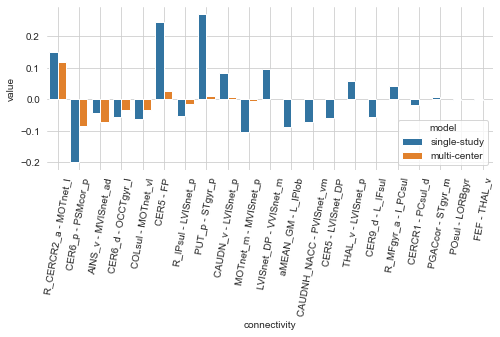

In [351]:
plt.figure(figsize=(8, 3))
sns.barplot(data=rpnonly_melt, x='connectivity', y='value', hue='model')
plt.xticks(rotation=80)
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

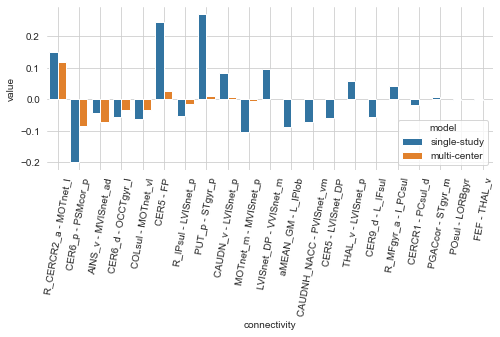

In [339]:
plt.figure(figsize=(8, 3))
sns.barplot(data=rpnonly_melt, x='connectivity', y='value', hue='model')
plt.xticks(rotation=80)
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

In [50]:
def polar_plot(model, weight, actual):
    # Initialise the spider plot by setting figure size and polar projection
    plt.figure(figsize=(2, 2))
    plt.subplot(polar=True)

    weight.append(weight[0])
    theta = np.linspace(0, 2 * np.pi, len(weight))

    # Arrange the grid into number of sales equal parts in degrees
    lines, lab = plt.thetagrids(range(0, 360, int(360/len(model))), (model))
    # Plot actual sales graph
    #plt.plot(theta, weight)
    plt.fill_between(theta, np.repeat(-0.1, len(weight)), weight, color='b', alpha=1)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    #plt.ylim((min(np.min(weight), -0.1),np.max(weight)))
    plt.ylim((-0.1,0.3))
    plt.plot(theta, np.repeat(0, len(weight)), color='gray', linestyle=':')
    plt.plot(theta, np.repeat(actual, len(weight)), color='red', linestyle=':')

ref = np.triu(get_weights(models['study1']))
abs_ref = np.abs(ref)
model_names = ['study1', 'study1+2', 'study2', 'study2+3', 'study3', 'study1+3']

#num = np.sum(ref!=0)
num = 40

for i in range(num):
    print(np.max(abs_ref))
    nextmax_idx = np.argwhere(abs_ref==np.max(abs_ref))
    if nextmax_idx.shape[0] != 1:
          raise RuntimeError('tie:', nextmax_idx)
    else:
        nextmax_idx = nextmax_idx[0]
        labs = labels[nextmax_idx]
        weights = []
        for m in model_names:
            weights.append(get_weights(models[m])[nextmax_idx[0], nextmax_idx[1]])
        polar_plot(model_names, weights, abs_ref[nextmax_idx[0], nextmax_idx[1]])
        plt.title(labs[0] + "  -  " + labs[1] + "  ({:.3f})".format(ref[nextmax_idx[0], nextmax_idx[1]]))
        print(weights)
        plt.show()
                 
    abs_ref[nextmax_idx[0], nextmax_idx[1]] = -np.inf

array(['GlobSig', 'CER6_p', 'CER7ab', 'R_CERCR2_p', 'CER9_v', 'CER6_a',
       'L_CERCR2_a', 'CER9_d', 'CER9_m', 'CER7b_m', 'L_CERCR2_p',
       'CER7b_l', 'N', 'CERCR1', 'CER6_d', 'CER5', 'R_CERCR2_a',
       'POsul_d', 'POsul_v', 'VMPFcor_p', 'R_MTgyr_a', 'L_ANGgyr',
       'L_MTgyr_p', 'L_MTgyr_a', 'DMPFC_ar', 'L_SFsul_a', 'DMPFcor_ac',
       'PCcor', 'POsul', 'L_IPlob', 'PGACcor', 'VMPFcor_a', 'PRC_d',
       'SFgyr_ad', 'L_IPlob.1', 'R_ANGgyr', 'PRC_v', 'R_MTgyr_p',
       'PRC_d.1', 'R_MFgyr_a', 'L_DVIS_v', 'SPlob', 'R_VLPFcor',
       'FUSgyr_vl', 'R_IFsul', 'FP', 'R_DVIS_v', 'L_FP_l', 'SPlob.1',
       'L_MFgyr_pc', 'L_VLPFcor', 'OCCTgyr_l', 'ACcor_d', 'L_MFgyr_pr',
       'R_MFgyr_p', 'R_IPsul', 'L_IFsul', 'DVIS_s', 'FUSgyr_dl',
       'R_SFsul', 'R_IPlob', 'R_FP_l', 'R_PORB', 'DMPFcor_p', 'L_IPsul',
       'L_MFgyr_a', 'DVIS_vl', 'CAUDNH_NACC', 'COLsul', 'LORBgyr',
       'ITgyr', 'STgyr_a', 'MORBgyr', 'PINS_v', 'TP', 'HIPP', 'AMY',
       'PIsul', 'CERVM', 'L_MOTnet_dl', 'M

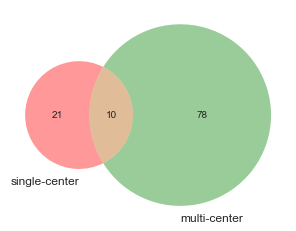

In [366]:
# library
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib_venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
venn2(subsets = (21,78, 10), set_labels = ('single-center', 'multi-center'))
plt.savefig('venn_num_conns.pdf')  

In [362]:
rpnonly['single-study'].abs().sum() #1.770
rpnonly['multi-center'].abs().sum() #0.404
table['multi-center'].abs().sum()   #2.850


2.8047138160419203

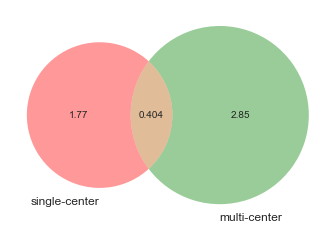

In [367]:
venn2(subsets = (1.77,2.85, 0.404), set_labels = ('single-center', 'multi-center'))
#plt.savefig('venn_abs_weights.pdf')  